## RAG Agent

In [60]:
import json
import time
import torch
import os

from langchain_core.documents import Document
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate, AIMessagePromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama
from langchain_qdrant import QdrantVectorStore
from langgraph.graph import START, StateGraph
from qdrant_client import QdrantClient
from qdrant_client.models import Filter, FieldCondition, MatchValue, Distance, VectorParams
from typing_extensions import List, TypedDict, Annotated, Literal

#---------------------------------------------------------------------------------------
# set parameters
#---------------------------------------------------------------------------------------
# general parameters
user_ID = "user_1" # user ID for the chat history

# Qdrant parameters
document_collection_name = "demo_collection" # name of the company documents Qdrant collection
product_collection_name = "product_collection" # name of the company documents Qdrant collection
memory_collection_name = "memory_collection" # name of the company documents Qdrant collection
history_collection_name = "history_collection"
db_path = "test_rag_db" # path to the Qdrant database
distance = Distance.COSINE # distance metric for the Qdrant database

# embedding model parameters
model_name = "sentence-transformers/all-mpnet-base-v2" # embedding model name

# LLM parameters
llm_name = "llama3.1:8b" # name of the LLM model
k = 8 # number of documents to retrieve from the RAG database
os.environ["TRANSFORMERS_NO_TF"] = "1"
#---------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------
# connect to Qdrant database and vector stores
#----------------------------------------------------------------------------------------
# embedding model used for the Qdrant database
embeddings = HuggingFaceEmbeddings(model_name=model_name)

# Initialize the Qdrant client with a local path
db_client = QdrantClient(path=db_path)

if not db_client.collection_exists(document_collection_name) or not db_client.collection_exists(product_collection_name):
    raise ValueError(f"Collection {document_collection_name} or {product_collection_name} does not exist.")

document_vector_store = QdrantVectorStore(
    client=db_client,
    collection_name=document_collection_name,
    embedding=embeddings,
)

product_vector_store = QdrantVectorStore(
    client=db_client,
    collection_name=product_collection_name,
    embedding=embeddings,
)

if not db_client.collection_exists(memory_collection_name):
    # create history collection if it doesn't exist

    vector_length = len(embeddings.embed_documents(["dummy"])[0])  # get vector length from dummy embedding
    db_client.create_collection(
        collection_name=memory_collection_name,
        vectors_config=VectorParams(size=vector_length, distance=distance),
    )

memory_vector_store = QdrantVectorStore(
    client=db_client,
    collection_name=memory_collection_name,
    embedding=embeddings,
)

if not db_client.collection_exists(history_collection_name):
    # create history collection if it doesn't exist

    vector_length = len(embeddings.embed_documents(["dummy"])[0])  # get vector length from dummy embedding
    db_client.create_collection(
        collection_name=history_collection_name,
        vectors_config=VectorParams(size=vector_length, distance=distance),
    )

history_vector_store = QdrantVectorStore(
    client=db_client,
    collection_name=history_collection_name,
    embedding=embeddings,
)
#-----------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------
# set up promt + LLM and load companies + chat history
#---------------------------------------------------------------------------------------
# Load comanies 
with open("companies.json") as f:
    companies = json.load(f)

# Load chat memory for the user
chat_memory = db_client.scroll(
    collection_name=memory_collection_name,
    scroll_filter=Filter(must=[FieldCondition(key="user_ID", match=MatchValue(value=user_ID))]),
    limit=1,
)
chat_memory = chat_memory[0][0].payload["chat_memory"] if chat_memory and len(chat_memory[0]) > 0 else ""

# Load chat history for the user
chat_history = db_client.scroll(
    collection_name=history_collection_name,
    scroll_filter=Filter(must=[FieldCondition(key="user_ID", match=MatchValue(value=user_ID))]),
    limit=1,
)
chat_history = chat_history[0][0].payload["chat_memory"] if chat_history and len(chat_history[0]) > 0 else ""

# Define prompt for question-answering
system_message = SystemMessage("You are a helpful AI assistant for question-answering tasks, trying to help the user to find brands and products that align with their values. The provided chat history includes facts about the user you are speaking with.")
memory_message = AIMessagePromptTemplate.from_template("Chat memory: {chat_memory}") 
history_message = AIMessagePromptTemplate.from_template("Chat history: {chat_history}") 
input_message = HumanMessagePromptTemplate.from_template("""Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
                                                            Question: {question} Please provide a detailed answer to the question containing all the information provided in the context.
                                                            Context: {context} 
                                                            Answer:""") # create input message

prompt = ChatPromptTemplate.from_messages([system_message, memory_message, history_message, input_message]) # create prompt template

# Define LLM for question-answering
device = ["cuda:0"] if torch.cuda.is_available() else ["cpu"]
print(f"Using device: {device}")
llm = ChatOllama(model=llm_name)


#-------------------------------------------------------------------------------------------
# Define state graph for the application
#---------------------------------------------------------------------------------------
# define Search query structure
class Search(TypedDict):

    query: Annotated[str, ..., "Search query to run."]
    company: Annotated[
        #Literal[tuple(companies.keys())],     # list of all companies in the database (add all companies here), ev also add topic filter
        Literal["Beiersdorf", "L'Oréal"],     # list of all companies in the database (add all companies here), ev also add topic filter
        ...,
        "company to query.",
    ]
    topic: Annotated[
        Literal["location,workforce,shareholders", "ethics", "environment"],     # list of topics
        ...,
        "topic the query is about.",
    ]

# Define state for application
class State(TypedDict):
    chat_memory : str
    chat_history: str
    question: str
    query: Search
    context: List[Document]
    answer: str
    documet_db: QdrantVectorStore 
    product_db: QdrantVectorStore 
    memory_db: QdrantVectorStore
    history_db: QdrantVectorStore 
    client: QdrantClient 
    
# Define application steps
def analyze_query(state: State):
    """
    Extract the company and topic from the question and create a structured query.
    """

    print(state["chat_memory"])
    print(state["chat_history"])
    structured_llm = llm.with_structured_output(Search)
    #TODO properly input the chat memory and question
    query = structured_llm.invoke("chat memory:\n" + state["chat_memory"] + "\n\n" "chat history:\n" + state["chat_history"] + "\n\n" + "question:" + state["question"] + "\n\n" + "if there is conflicting information, use the information contained in the question.")

    # map company info to location, workforce, shareholders (as this is how it is stored in the database but there is less ambiguity using the other term)
    if query["topic"] == "location,workforce,shareholders":
        query["topic"] = "company info"

    return {"query": query}

def retrieve(state: State):
    """
    Retrieve relevant documents from the document database based on the structured query.
    """
    query = state["query"]
    retrieved_docs = state["documet_db"].similarity_search(
        query["query"],
        filter=Filter(must=[FieldCondition(key="metadata.company", match=MatchValue(value=query["company"])),
                            FieldCondition(key="metadata.topic", match=MatchValue(value=query["topic"])),
                            ]),
        k=k,
    )
    return {"context": retrieved_docs}

def generate(state: State):
    """
    Generate an answer based on the retrieved documents, the chat history and the question.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], 
                              "context": docs_content,
                              "chat_memory": state["chat_memory"],
                              "chat_history": state["chat_history"]})
    response = llm.invoke(messages)
    return {"answer": response.content}

def summarize_memory(state: State):
    """
    Summarize the previous chat history, question, and answer into a new chat history.
    """
    memory_summarization_prompt = ChatPromptTemplate.from_messages(
        [
            state["chat_memory"],
            state["chat_history"],
            state["question"],
            state["answer"],
            (
                "user",
                "From the above messages derive what can be known about the purchase preferences of the user (for example, they care about whether a company does animal testing.) You can also include some brand and products of interest. Please mainly focus on a summary of the user preferences, don't include extra information about companies etc. If there is conflicting information save the most recent one.",
            ),
        ]
    )

    summary = llm.invoke(memory_summarization_prompt.invoke({})).content
    return {"chat_memory": summary}

def summarize_history(state: State):
    """
    Summarize the previous chat history, question, and answer into a new chat history.
    """
    history_summarization_prompt = ChatPromptTemplate.from_messages(
        [
            state["chat_history"],
            state["question"],
            state["answer"],
            (
                "user",
                "Make a summary of the conversation so far, focusing on brands, products and issues that have been discussed.",
            ),
        ]
    )

    summary = llm.invoke(history_summarization_prompt.invoke({})).content
    return {"chat_history": summary}

def save_memory(state: State):
    """
    Save the chat history to the history database (using the user_id).
    """
    state["client"].set_payload(
        collection_name=state["memory_db"].collection_name,
        payload={"user_ID": user_ID, "chat_memory": state["chat_memory"]},
        points=Filter(must=[FieldCondition(key="user_ID", match=MatchValue(value=user_ID))]),
    )

def save_history(state: State):
    """
    Save the chat history to the history database (using the user_id).
    """
    state["client"].set_payload(
        collection_name=state["history_db"].collection_name,
        payload={"user_ID": user_ID, "chat_history": state["chat_history"]},
        points=Filter(must=[FieldCondition(key="user_ID", match=MatchValue(value=user_ID))]),
    )

# build and compile the state graph
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate, summarize_memory, save_memory, summarize_history, save_history])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()
#---------------------------------------------------------------------------------------


# function to run the state graph with predefined database
def invoke_graph(graph: StateGraph, question: str, chat_memory: str, chat_history: str, 
                 db_client: QdrantClient = db_client, 
                 document_db: QdrantVectorStore = document_vector_store, 
                 product_db: QdrantVectorStore = product_vector_store, 
                 memory_db: QdrantVectorStore = memory_vector_store,
                 history_db: QdrantVectorStore = history_vector_store) -> str:
    """
    Run the state graph with the given question and chat history.

    Params:
        graph (StateGraph): The state graph to run.
        question (str): The question asked by the user.
        chat_history (str): The chat history for the user.
        Optional:
            db_client (QdrantClient): The Qdrant client to use.
            document_db (QdrantVectorStore): The document vector store to use.
            product_db (QdrantVectorStore): The product vector store to use.
            history_db (QdrantVectorStore): The history vector store to use.
    """
    state = State(
        chat_memory=chat_memory,
        chat_history = chat_history,
        question=question,
        query={},
        context=[],
        answer="",
        client=db_client,
        documet_db=document_db,
        product_db=product_db,
        memory_db=memory_db,
        history_db = history_db
    )
    return graph.invoke(state)

Using device: ['cpu']


In [61]:
print(time.strftime("%H:%M:%S", time.localtime()))
result = invoke_graph(graph=graph,
                      question = "Can you tell me if Beiersdorf conducts animal testing?",
                      chat_memory = chat_memory,
                      chat_history = chat_history)
chat_memory = result["chat_memory"] 
chat_history = result["chat_history"]

print(f'Metadata: {result["query"]["company"]}, {result["query"]["topic"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(f'Chat memory: {result["chat_memory"]}')
print(f'Chat history: {result["chat_history"]}')

print(time.strftime("%H:%M:%S", time.localtime()))
print(f'\nAnswer LLM: {llm.invoke("Can you tell me if Beiersdorf conducts animal testing?").content}')
print(time.strftime("%H:%M:%S", time.localtime()))

10:32:33


Metadata: Beiersdorf, ethics
Context: [Document(metadata={'company': 'Beiersdorf', 'topic': 'ethics', 'source_file': 'beiersdorf_ethics.json', '_id': 23, '_collection_name': 'demo_collection'}, page_content='certified cruelty-free brand by PETA or the Leaping Bunny program, as its compliance with Chinese regulations means some products may still be subject to animal testing in specific markets. However, the company is a member of the European Partnership for Alternative Approaches to Animal Testing (EPAA), reflecting its investment in non-animal research methods. **Labor Conditions:** Beiersdorf adheres to international labor standards and is a member of the United Nations Global Compact, committing to fair labor practices, human rights, and anti-corruption measures. The company’s 2022 Sustainability Report highlights initiatives to ensure safe working conditions, fair wages, and employee development programs across its supply chain. Independent audits, such as those by the 

In [101]:
db_client.close()

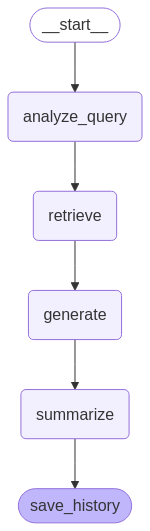

In [36]:
from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))

## Test conversation

In [ ]:
result = invoke_graph(graph=graph,
                      question = "Tell me more about the company.",
                      chat_memory= chat_memory,
                      chat_history = chat_history)



print(f'Metadata: {result["query"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(f'Chat history: {result["chat_history"]}')
print(f'Chat memory: {result["chat_memory"]}')
chat_history = result["chat_history"]
chat_memory = result["chat_memory"]

Based on the provided context, here's what can be known about the user's purchase preferences:

* The user values cruelty-free and animal-friendly products.
* They are likely to prioritize brands that do not conduct animal testing or support alternative methods.
* They may prefer purchasing from companies that have certifications such as PETA or the Leaping Bunny program.
* They might consider supporting European brands that have a strong commitment to non-animal research methods. 

Some possible product preferences based on this information could include skin care products, cosmetics, and personal care items that are certified cruelty-free or made by companies with a strong commitment to animal welfare.
Here's a summary of our conversation:

* We discussed Beiersdorf, a company behind various cosmetic products.
* The main topic was whether Beiersdorf conducts animal testing for its products.
* According to available information, Beiersdorf does not conduct animal testing for its cosme

In [63]:
result = invoke_graph(graph=graph,
                      question = "I am interesting in getting some mask sheets from a European company. Can you recommend some good ones?",
                      chat_history = chat_history,
                      chat_memory = chat_memory)



print(f'Metadata: {result["query"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(f'Chat history: {result["chat_history"]}')
print(f'Chat memory: {result["chat_memory"]}')
chat_history = result["chat_history"]
chat_memory = result["chat_memory"]

Here's a summary of the user's purchase preferences:

* The user values cruelty-free and animal-friendly products.
* They prioritize brands that do not conduct animal testing or support alternative methods.
* They prefer purchasing from companies with certifications such as PETA or the Leaping Bunny program, although some European brands without these certifications may also be considered.
* They are likely to research a company's stance on animal testing and its commitment to non-animal research methods before making a purchase. 

Some possible product preferences based on this information could include:

* Skin care products that are certified cruelty-free or made by companies with a strong commitment to animal welfare, such as Nivea (Beiersdorf) or other European brands.
* Cosmetics and personal care items from companies like La Prairie (owned by Beiersdorf), Eucerin (also owned by Beiersdorf).
* Products from companies that are members of organizations promoting alternative testing

In [65]:
result = invoke_graph(graph=graph,
                      question = "I specifically want a face mask. I want it to be from a brand that is European and does no animal testing.",
                      chat_history = chat_history,
                      chat_memory = chat_memory)

print(f'previous chat_history: {chat_history}')

print(f'Metadata: {result["query"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(f'Chat history: {result["chat_history"]}')
chat_history = result["chat_history"]
chat_memory = result["chat_memory"]

Here's a summary of the user's purchase preferences:

* The user values cruelty-free and animal-friendly products.
* They prioritize brands that do not conduct animal testing or support alternative methods.
* They prefer purchasing from companies with certifications such as PETA or the Leaping Bunny program, although some European brands without these certifications may also be considered.
* They are likely to research a company's stance on animal testing and its commitment to non-animal research methods before making a purchase.
Here's a summary of our conversation:

**Brands:**

* Beiersdorf (multinational company behind Nivea, Eucerin, and La Prairie)
* European beauty and skincare brands:
	+ La Roche-Posay (France)
	+ Dr. Hauschka (Germany)
	+ L'Occitane en Provence (France)

**Products:**

* Cosmetic products (e.g., skincare, body care) from Beiersdorf
* Mask sheets (although not a specific product discussed in the context of Beiersdorf or other European brands mentioned)

**Issue

### Clear chat history

In [59]:
db_client.delete(collection_name=memory_collection_name, points_selector=Filter(must=[FieldCondition(key="user_ID", match=MatchValue(value=user_ID))])) # delete user chat history from database
db_client.delete(collection_name=history_collection_name, points_selector=Filter(must=[FieldCondition(key="user_ID", match=MatchValue(value=user_ID))])) # delete user chat history from database
db_client.close() # close the database connection